## Multi-Modal

This is a fork of Multimodal RAG with Milvus Standalone running against Ollama with llava:7b

I replaced GPT-4o with Ollama hosted llava:7b.

I replaced the Amazon product data with "ghosts"

* https://github.com/milvus-io/bootcamp/blob/master/bootcamp/tutorials/quickstart/multimodal_rag_with_milvus.ipynb


In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)
from dotenv import load_dotenv
load_dotenv(override=True)

from tqdm.notebook import tqdm
from PIL import Image
from sentence_transformers import SentenceTransformer
from pymilvus import MilvusClient
import requests
from pymilvus import (
   utility,
   FieldSchema, CollectionSchema, DataType,
   Collection, AnnSearchRequest, RRFRanker, connections,
)

In [3]:
from pymilvus import connections
from pymilvus import utility
from pymilvus import FieldSchema, CollectionSchema, DataType, Collection
from pymilvus import MilvusClient

MILVUS_URL = "./ghostsarereal.db" 
milvus_client = MilvusClient(uri=MILVUS_URL)
connections.connect(uri=MILVUS_URL)

In [5]:
from IPython.display import display
from PIL import Image
import requests
from io import BytesIO
from pymilvus import AnnSearchRequest, RRFRanker, WeightedRanker
import time
from pymilvus import WeightedRanker
from IPython.display import display, Markdown

In [5]:
#!wget https://huggingface.co/BAAI/bge-visualized/resolve/main/Visualized_base_en_v1.5.pth

In [6]:
#!pip3 install -q --upgrade pymilvus openai datasets opencv-python timm einops ftfy peft tqdm

In [7]:
#!pip install git+https://github.com/FlagOpen/FlagEmbedding.git

In [6]:
import torch
from FlagEmbedding.visual.modeling import Visualized_BGE

#### Multimodal Encoder
class Encoder:
    def __init__(self, model_name: str, model_path: str):
        self.model = Visualized_BGE(model_name_bge=model_name, model_weight=model_path)
        self.model.eval()

    def encode_query(self, image_path: str, text: str) -> list[float]:
        with torch.no_grad():
            query_emb = self.model.encode(image=image_path, text=text)
        return query_emb.tolist()[0]

    def encode_image(self, image_path: str) -> list[float]:
        with torch.no_grad():
            query_emb = self.model.encode(image=image_path)
        return query_emb.tolist()[0]


model_name = "BAAI/bge-base-en-v1.5"
model_path = "./Visualized_base_en_v1.5.pth"  # Change to your own value if using a different model path
encoder = Encoder(model_name, model_path)

In [7]:
import os
from tqdm import tqdm
from glob import glob

# Generate embeddings for the image dataset
data_dir = [ 
    "/Users/timothyspann/Desktop/halloween", 
    "/Users/timothyspann/Desktop/ghostload",  
    "/Users/timothyspann/Desktop/standardghosts",
    "/Users/timothyspann/Desktop/ghosts" ]

image_list = []

for imgdir in data_dir:
    image_list = image_list + glob(os.path.join(imgdir, "*.jpg") ) 
    image_list = image_list + glob(os.path.join(imgdir, "*.png") ) 
    image_list = image_list + glob(os.path.join(imgdir, "*.gif") ) 

image_dict = {}
for image_path in tqdm(image_list, desc="Generating image embeddings: "):
    try:
        image_dict[image_path] = encoder.encode_image(image_path)
    except Exception as e:
        print(f"Failed to generate embedding for {image_path}. Skipped.")
        continue
print("Number of encoded images:", len(image_dict))

Generating image embeddings: 100%|███████████████████████████| 210/210 [00:38<00:00,  5.48it/s]

Number of encoded images: 210


In [18]:
from pymilvus import MilvusClient

dim = len(list(image_dict.values())[0])
collection_name = "ghostslocal"

if milvus_client.has_collection(collection_name=collection_name):
    print(collection_name + " exists")
else:
    milvus_client.create_collection(
        collection_name=collection_name,
        auto_id=True,
        dimension=dim,
        enable_dynamic_field=True,
    )
    # Insert data into collection
    milvus_client.insert(
        collection_name=collection_name,
        data=[{"image_path": k, "vector": v} for k, v in image_dict.items()],
    )

ghostslocal exists


search latency: 0.4555 seconds


Query:  computer with this image theme


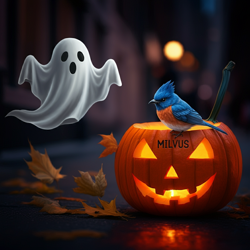

Search Results 


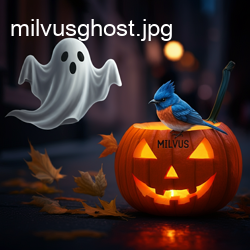

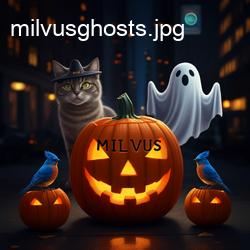

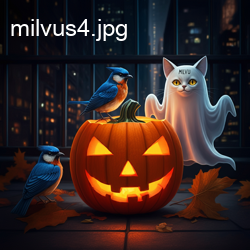

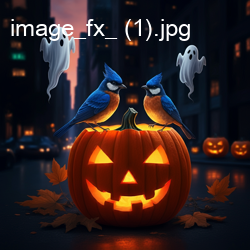

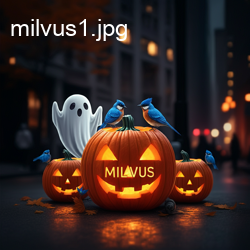

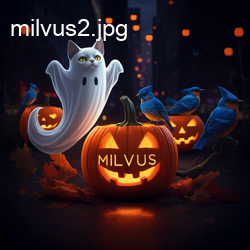

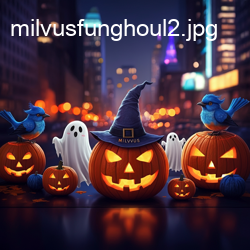

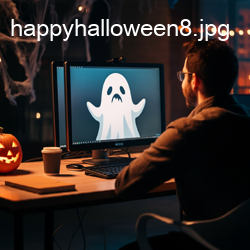

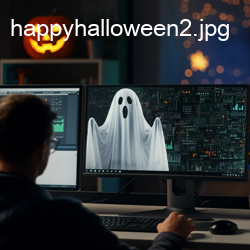

['/Users/timothyspann/Desktop/halloween/milvusghost.jpg', '/Users/timothyspann/Desktop/halloween/milvusghosts.jpg', '/Users/timothyspann/Desktop/halloween/milvus4.jpg', '/Users/timothyspann/Desktop/halloween/image_fx_ (1).jpg', '/Users/timothyspann/Desktop/halloween/milvus1.jpg', '/Users/timothyspann/Desktop/halloween/milvus2.jpg', '/Users/timothyspann/Desktop/halloween/milvusfunghoul2.jpg', '/Users/timothyspann/Desktop/halloween/happyhalloween8.jpg', '/Users/timothyspann/Desktop/halloween/happyhalloween2.jpg']


In [19]:
from PIL import Image, ImageDraw, ImageFont

query_image = "/Users/timothyspann/Desktop/halloween/milvusghost.jpg" 
query_text = "computer with this image theme"

t0 = time.time()

# Generate query embedding given image and text instructions
query_vec = encoder.encode_query(image_path=query_image, text=query_text)

search_results = milvus_client.search(
        data=[query_vec],
    collection_name="ghostslocal",
    limit=9,  # Max number of search results to return
    output_fields=["image_path"],
    search_params={"metric_type": "COSINE", "params": {}},
)[0]

t1 = time.time()
print(f"search latency: {round(t1-t0, 4)} seconds\n\n")

retrieved_images = []

print("Query:  " + str(query_text))

query_image
img = Image.open(query_image)
img = img.resize((250, 250))

display(img)

print("Search Results ")

for data in search_results:
    img = Image.open(data["entity"]["image_path"])
    img = img.resize((250, 250))

    draw = ImageDraw.Draw(img)

    rawtext = str(data["entity"]["image_path"])
    pathlist = rawtext.split("/")
    lenpat = len(pathlist)
    text = str(pathlist[lenpat-1])
    text_position = (10, 10)  # (x, y) coordinates
    font = ImageFont.truetype("Arial Unicode.ttf", 24)    
    draw.text(text_position, text, fill=(255, 255, 255), font=font)  # White color

    retrieved_images.append(data["entity"]["image_path"])
    display(img)

print(retrieved_images)


In [10]:
import numpy as np
import cv2

img_height = 300
img_width = 300
row_count = 3

def create_panoramic_view(query_image_path: str, retrieved_images: list) -> np.ndarray:
    """
    creates a 5x5 panoramic view image from a list of images

    args:
        images: list of images to be combined

    returns:
        np.ndarray: the panoramic view image
    """
    panoramic_width = img_width * row_count
    panoramic_height = img_height * row_count
    panoramic_image = np.full(
        (panoramic_height, panoramic_width, 3), 255, dtype=np.uint8
    )

    # create and resize the query image with a blue border
    query_image_null = np.full((panoramic_height, img_width, 3), 255, dtype=np.uint8)
    query_image = Image.open(query_image_path).convert("RGB")
    query_array = np.array(query_image)[:, :, ::-1]
    resized_image = cv2.resize(query_array, (img_width, img_height))

    border_size = 10
    blue = (255, 0, 0)  # blue color in BGR
    bordered_query_image = cv2.copyMakeBorder(
        resized_image,
        border_size,
        border_size,
        border_size,
        border_size,
        cv2.BORDER_CONSTANT,
        value=blue,
    )

    query_image_null[img_height * 2 : img_height * 3, 0:img_width] = cv2.resize(
        bordered_query_image, (img_width, img_height)
    )

    # add text "query" below the query image
    text = "query"
    font_scale = 1
    font_thickness = 2
    text_org = (10, img_height * 3 + 30)
    cv2.putText(
        query_image_null,
        text,
        text_org,
        cv2.FONT_HERSHEY_SIMPLEX,
        font_scale,
        blue,
        font_thickness,
        cv2.LINE_AA,
    )

    # combine the rest of the images into the panoramic view
    retrieved_imgs = [
        np.array(Image.open(img).convert("RGB"))[:, :, ::-1] for img in retrieved_images
    ]
    for i, image in enumerate(retrieved_imgs):
        image = cv2.resize(image, (img_width - 4, img_height - 4))
        row = i // row_count
        col = i % row_count
        start_row = row * img_height
        start_col = col * img_width

        border_size = 2
        bordered_image = cv2.copyMakeBorder(
            image,
            border_size,
            border_size,
            border_size,
            border_size,
            cv2.BORDER_CONSTANT,
            value=(0, 0, 0),
        )
        panoramic_image[
            start_row : start_row + img_height, start_col : start_col + img_width
        ] = bordered_image

        # add red index numbers to each image
        text = str(i)
        org = (start_col + 50, start_row + 30)
        (font_width, font_height), baseline = cv2.getTextSize(
            text, cv2.FONT_HERSHEY_SIMPLEX, 1, 2
        )

        top_left = (org[0] - 48, start_row + 2)
        bottom_right = (org[0] - 48 + font_width + 5, org[1] + baseline + 5)

        cv2.rectangle(
            panoramic_image, top_left, bottom_right, (255, 255, 255), cv2.FILLED
        )
        cv2.putText(
            panoramic_image,
            text,
            (start_col + 10, start_row + 30),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            (0, 0, 255),
            2,
            cv2.LINE_AA,
        )

    # combine the query image with the panoramic view
    panoramic_image = np.hstack([query_image_null, panoramic_image])
    return panoramic_image

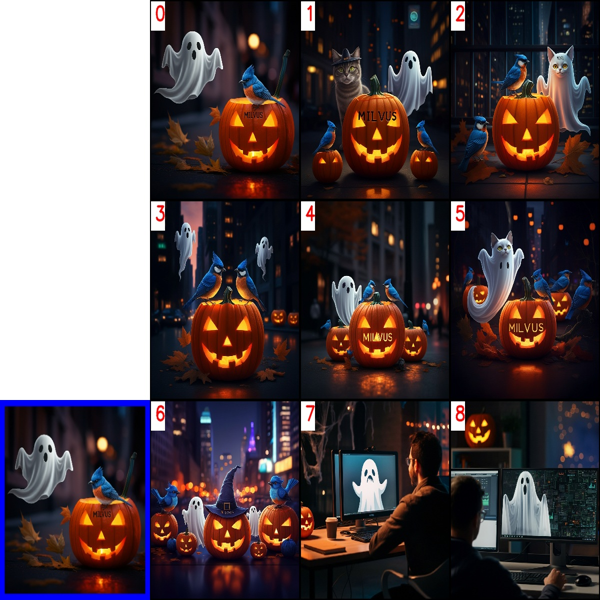

In [11]:
from PIL import Image

data_dir = "/Users/timothyspann/Desktop/ghosts/"

combined_image_path = os.path.join(data_dir, "combined_image.jpg")
panoramic_image = create_panoramic_view(query_image, retrieved_images)
cv2.imwrite(combined_image_path, panoramic_image)

combined_image = Image.open(combined_image_path)
show_combined_image = combined_image.resize((600, 600))
#show_combined_image.show()
display(show_combined_image)

In [12]:
import requests
import base64
import ollama

def generate_ranking_explanation(
    combined_image_path: str, caption: str, infos: dict = None
) -> tuple[list[int], str]:
    with open(combined_image_path, "rb") as image_file:
        base64_image = base64.b64encode(image_file.read()).decode("utf-8")

    information = (
        "You are responsible for ranking results for a Composed Image Retrieval. "
        "The user retrieves an image with an 'instruction' indicating their retrieval intent. "
        "For example, if the user queries a red car with the instruction 'change this car to blue,' a similar type of car in blue would be ranked higher in the results. "
        "Now you would receive instruction and query image with blue border. Every item has its red index number in its top left. Do not misunderstand it. "
        f"User instruction: {caption} \n\n"
    )

    # add additional information for each image
    if infos:
        for i, info in enumerate(infos["product"]):
            information += f"{i}. {info}\n"

    information += (
        "Provide a new ranked list of indices from most suitable to least suitable, followed by an explanation for the top 1 most suitable item only. "
        "The format of the response has to be 'Ranked list: []' with the indices in brackets as integers, followed by 'Reasons:' plus the explanation why this most fit user's query intent."
    )

    headers = { } 

    payload = {
        "model": "llava:7b",
        "messages": [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": information},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
                    },
                ],
            }
        ],
        "max_tokens": 30000,
    }

    response = requests.post(
        "http://localhost:11434/v1/chat/completions", headers=headers, json=payload
    )

    #print(response)
    #print(response.json())
    result = response.json()["choices"][0]["message"]["content"]

    print(result)
    # parse the ranked indices from the response
    start_idx = result.find("[")
    end_idx = result.find("]")
    ranked_indices_str = result[start_idx + 1 : end_idx].split(",")
    ranked_indices = [int(index.strip()) for index in ranked_indices_str]

    # extract explanation
    explanation = result[end_idx + 1 :].strip()
    return ranked_indices, explanation

In [20]:
ranked_indices, explanation = generate_ranking_explanation(
    combined_image_path, query_text
)

 Here is the ranked list of indices from most suitable to least suitable, followed by an explanation for the top 1:

Ranked List: [2, 4, 9, 7, 6]
Reasons:
The top 1 image (index 6) is most likely considered suitable because it directly fits the user's instruction "computer with this image theme." The image contains a Halloween-themed setup that includes a computer along with other Halloween decorations such as pumpkins and ghosts. This closely aligns with the concept of a 'computer with Halloween' and is, therefore, ranked number 1 for being the closest match to the user's request.

The higher a result appears on this list, the more relevant it is to what the user queried. The lower numbers on this list indicate images that are less relevant to the user's query or include less of the requested elements. Each number in the image you provided indicates different ranked items for the composed image retrieval system. 


Reasons: The top image is ranked number one for two main reasons. First, it captures the Halloween theme more prominently by featuring a detailed and colorful witch's costume along with jack-o-lanterns and a spooky backdrop. This visual representation of Halloween is likely to cater better to the user's retrieval intent of an image related to the Halloween theme. The second reason is that it provides more context regarding where this scene takes place, which is important for the instruction 'change this car to blue.' In this particular scene, there is a car in a Halloween-themed setting with the witch nearby and some jack-o-lanterns on the ground. The context suggests a festive night or event occurring, making it more fitting for the instruction provided by the user. Other images in the collage do not provide the same level of thematic representation or context that aligns well with the Halloween theme and the user's retrieval intent.


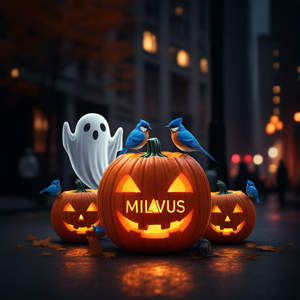

In [14]:
print(explanation)

best_index = ranked_indices[0]
best_img = Image.open(retrieved_images[best_index])
best_img = best_img.resize((300, 300))
display(best_img)

search latency: 0.4339 seconds


Query:  A scene in New York City with ghosts, cats and pumpkins


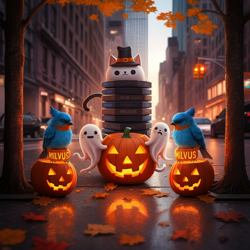

Search Results 


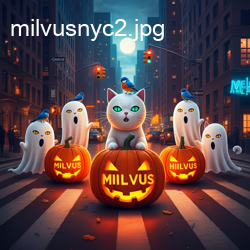

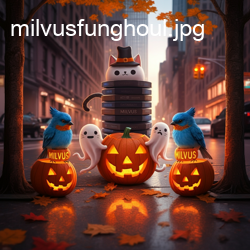

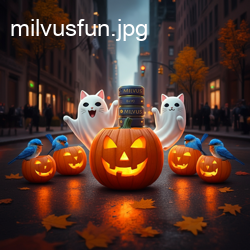

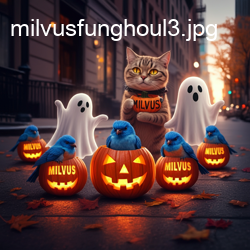

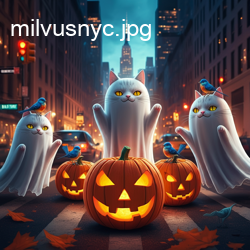

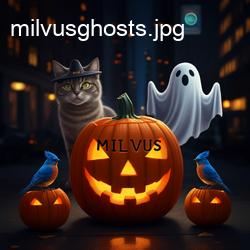

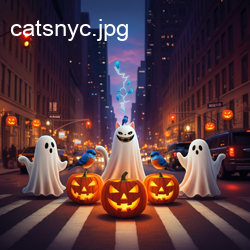

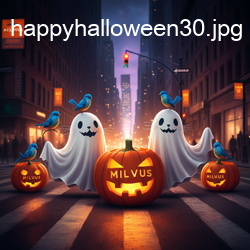

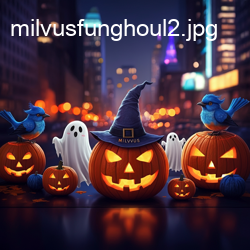

['/Users/timothyspann/Desktop/halloween/milvusnyc2.jpg', '/Users/timothyspann/Desktop/halloween/milvusfunghoul.jpg', '/Users/timothyspann/Desktop/halloween/milvusfun.jpg', '/Users/timothyspann/Desktop/halloween/milvusfunghoul3.jpg', '/Users/timothyspann/Desktop/halloween/milvusnyc.jpg', '/Users/timothyspann/Desktop/halloween/milvusghosts.jpg', '/Users/timothyspann/Desktop/halloween/catsnyc.jpg', '/Users/timothyspann/Desktop/halloween/happyhalloween30.jpg', '/Users/timothyspann/Desktop/halloween/milvusfunghoul2.jpg']


In [15]:
from PIL import Image, ImageDraw, ImageFont

query_image = "/Users/timothyspann/Desktop/halloween/milvusfunghoul.jpg" 
query_text = "A scene in New York City with ghosts, cats and pumpkins"

t0 = time.time()

# Generate query embedding given image and text instructions
query_vec = encoder.encode_query(image_path=query_image, text=query_text)

search_results = milvus_client.search(
        data=[query_vec],
    collection_name="ghostslocal",
    limit=9,  # Max number of search results to return
    output_fields=["image_path"],
    search_params={"metric_type": "COSINE", "params": {}},
)[0]

t1 = time.time()
print(f"search latency: {round(t1-t0, 4)} seconds\n\n")
# print(results)

retrieved_images = []

print("Query:  " + str(query_text))

img = Image.open(query_image)
img = img.resize((250, 250))

display(img)

print("Search Results ")

for data in search_results:
    img = Image.open(data["entity"]["image_path"])
    img = img.resize((250, 250))

    draw = ImageDraw.Draw(img)

    rawtext = str(data["entity"]["image_path"])
    pathlist = rawtext.split("/")
    lenpat = len(pathlist)
    text = str(pathlist[lenpat-1])
    text_position = (10, 10)  # (x, y) coordinates
    font = ImageFont.truetype("Arial Unicode.ttf", 24)    
    draw.text(text_position, text, fill=(255, 255, 255), font=font)  # White color

    retrieved_images.append(data["entity"]["image_path"])
    display(img)

print(retrieved_images)

In [16]:
from slack_sdk import WebClient
from slack_sdk.errors import SlackApiError

### Turn off slack warnings
os.environ["SKIP_SLACK_SDK_WARNING"] = "false"

slack_token = os.environ.get("SLACK_BOT_TOKEN")
client = WebClient(token=slack_token)

try:
    for ghastlyimage in retrieved_images:
        response = ollama.chat(model="llava:7b",messages=[{'role': 'user',
                               'content': 'Describe this image:','images': [str(ghastlyimage)]}])

        responsetext = str( response['message']['content'] )
        print( responsetext )

    try:
        slackresponse =  str(responsetext).replace("**","*")           
        slackresponse = client.chat_postMessage(mrkdwn=True, channel="C06NE1FU6SE", text="", 
                                            blocks=[{"type": "section","text": {"type": "mrkdwn","text": str(slackresponse) +"\n" }}])
    except SlackApiError as e:
        print("Slack failed")

    try:
        response = client.files_upload_v2(
            channel="C06NE1FU6SE",
            file=ghastlyimage,
            title="Ghost Sighting",
            initial_comment="Ghost",
        )
    except SlackApiError as e:
        assert e.response["error"]
    # Slack
except Exception as e:
    descr.append("Describe Ghost")
    print("ollama chat exception: ")
    print(e)

 The image depicts a whimsical Halloween scene. In the foreground, there are four white cats with black eyes and noses, wearing costumes that resemble ghosts. The cat in the center is larger than the others and has a distinct blue collar, with a label reading "Milvus," and it's looking directly at the viewer. Behind these cats, there's a Halloween-themed cityscape at night, complete with streetlights, buildings, and a traffic light. A jack-o'-lantern is prominently displayed on the right side of the image.

At the bottom of the image, there's a blue bird perched above the text "MILVUS" in capital letters. The text appears to be a playful reference to the name of one of the cats. The overall atmosphere of the image is festive and spooky, appropriate for Halloween. 
 This is a digitally created and stylized image featuring an anthropomorphic cat dressed as a librarian, standing in front of a stack of books. In the background, there are three blue birds perched on branches above the cat's

In [17]:
!pip install -U duckduckgo-search


In [45]:
from duckduckgo_search import DDGS

try:
    results = DDGS().text("haunted host ghost image", max_results=5)
    print(results)
except Exception as e:
    print(e)

[{'title': 'Meet the Haunted Mansion Ghosts: Who Are They?', 'href': 'https://www.waltdisney.org/blog/haunted-mansion-ghosts', 'body': 'The Ghost Host. One of the most iconic ghosts in the Haunted Mansion is the Ghost Host. He welcomes guests and guides them through the various rooms and scenes, including the Portrait Chamber—informally referred to by many as the "stretching room"—and the Grand Ballroom. His voice, a blend of ominous and whimsical, sets the tone for the ...'}, {'title': 'Does Hatbox Ghost Ruin the Story of the Haunted Mansion? - Disney World', 'href': 'https://www.wdwinfo.com/walt-disney-world/does-hatbox-ghost-ruin-the-story-of-the-haunted-mansion/', 'body': 'Because he was removed from the Mansion shortly after the ride made its debut in 1969, he is known as the "lost ghost." Before the Haunted Mansion even opened at Disneyland in 1969 (and in 1971 at Walt Disney World), guests were excited to check out the latest animatronic from WED, as the Hatbox Ghost was heavily

## MINICPM
https://github.com/OpenBMB/MiniCPM-V

![mini](https://github.com/OpenBMB/MiniCPM-V/raw/main/assets/minicpmv.png)

### References

ollama run minicpm-v


#### Model Name inicpm-v:latest

````
 Model
    architecture        qwen2
    parameters          7.6B
    context length      32768
    embedding length    3584
    quantization        Q4_0

  Projector
    architecture        clip
    parameters          503.97M
    embedding length    1152
    dimensions          0
````



In [47]:
describeimage = "/Users/timothyspann/Desktop/halloween/happyhalloween30.jpg"
describeimage2 = "/Users/timothyspann/Desktop/halloween/catsnyc.jpg"

img = Image.open(describeimage)
img = img.resize((250, 250))
display(img)

img = Image.open(describeimage2)
img = img.resize((250, 250))
display(img)

response = ollama.chat(model="minicpm-v:latest",messages=[{'role': 'user',
                       'content': 'Provide all results in American English.  Describe these images, list all the elements in each image and me know which is better for a new york city fun halloween poster.:',
                        'images': [str(describeimage), str(describeimage2)]}])

responsetext = str( response['message']['content'] )
print( responsetext )

try:
    slackresponse =  str(responsetext).replace("**","*")                       
    slackresponse = client.chat_postMessage(mrkdwn=True, channel="C06NE1FU6SE", text="", 
                                        blocks=[{"type": "section","text": {"type": "mrkdwn","text": str(slackresponse) +"\n" }}])
except SlackApiError as e:
    print("Slack failed")

try:
    response = client.files_upload_v2(
        channel="C06NE1FU6SE",
        file=describeimage,
        title="Ghost Describe minicpm",
        initial_comment="Ghost",
    )
except SlackApiError as e:
    assert e.response["error"]

try:
    response = client.files_upload_v2(
        channel="C06NE1FU6SE",
        file=describeimage2,
        title="Ghost Describe minicpm",
        initial_comment="Ghost",
    )
except SlackApiError as e:
    assert e.response["error"]

The first image showcases a New York City street at night, adorned with festive Halloween decorations. The scene features several glowing orange pumpkins etched with faces and lit from within, reminiscent of jack-o'-lanterns. These are placed on the ground in various sizes alongside carved ghost figures that have a translucent white appearance, adding an eerie yet playful touch to the decoration.

The second image depicts a whimsical Halloween theme featuring cartoonish blue birds perched atop glowing orange pumpkins and ghostly ghosts with wide eyes. The background is set against the backdrop of New York City's iconic skyscrapers at dusk or nightfall. One pumpkin even has a glowing, animated face inside that emits sparks.

For a new New York City fun Halloween poster, the second image seems more appropriate due to its vibrant colors and playful cartoon-style characters which are likely to attract attention from passersby in bustling city streets like Times Square during October's fest

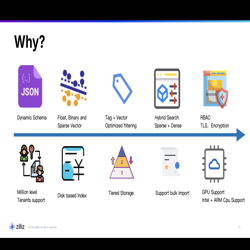

**Title:**
Why?

**Body Text:**
Dynamic Schema  
Floor, Binary and Sparse Vector  

Tag + Vector Optimized filtering  
Sparse Vector

Hybrid Search Sparse + Dense  
RBAC TLS, Encryption  

Million level Tenants support  
Disk based Index  
Tiered Storage  
Support bulk import
GPU Support Intel + ARM CPU Support


In [54]:
milvusimage = "/Users/timothyspann/Desktop/milvusdetails.png"

img = Image.open(milvusimage)
img = img.resize((640, 480))
display(img)

response = ollama.chat(model="minicpm-v:latest",messages=[{'role': 'user','content': 
                                                           '(English Translation) Extract all text from this image.:',
                        'images': [str(milvusimage)]}])

responsetext = str( response['message']['content'] )
print( responsetext )

try:
    slackresponse =  str(responsetext).replace("**","*")
    slackresponse = client.chat_postMessage(mrkdwn=True, channel="C06NE1FU6SE", text="", 
                                        blocks=[{"type": "section","text": {"type": "mrkdwn","text": str(slackresponse) +"\n" }}])
except SlackApiError as e:
    print("Slack failed")

try:
    response = client.files_upload_v2(
        channel="C06NE1FU6SE",
        file=milvusimage,
        title="Milvus",
        initial_comment="Milvus",
    )
except SlackApiError as e:
    assert e.response["error"]